# Data Inspection notebook for HECKTOR dataset

In [3]:
import os, glob

import numpy as np
import matplotlib.pyplot as plt

import SimpleITK as sitk

## Read image

In [247]:
def read_nifti(file_path, print_info=True):
    sitk_image = sitk.ReadImage(file_path)
    if print_info:
        print("\nLoaded image:", file_path.split('/')[-1])
        print("Patient ID:", file_path.split('/')[-1].split('_')[0])
        
        if '_ct' in file_path: modality = 'CT'
        elif '_pt' in file_path: modality = 'PT' 
        print("Modality:", modality)
        
        image_size = sitk_image.GetSize()
        pixel_spacing = sitk_image.GetSpacing()
        print("Image size:", image_size)
        print("Pixel spacing (mm):", pixel_spacing)
        print("Physical size (mm):", [image_size[i]*pixel_spacing[i] for i in range(3)])
        
        print("Components per pixel:", sitk_image.GetNumberOfComponentsPerPixel())
        
    return sitk_image

In [248]:
# Original image
image_path = "../data/hecktor_train/hecktor_nii/CHGJ007/CHGJ007_ct.nii.gz"
sitk_image = read_nifti(image_path)

# Resampled image
res_image_path = "../data/hecktor_train/resampled/CHGJ007_ct.nii.gz"
sitk_res_image = read_nifti(res_image_path)


Loaded image: CHGJ007_ct.nii.gz
Patient ID: CHGJ007
Modality: CT
Image size: (512, 512, 91)
Pixel spacing (mm): (0.9765620231628418, 0.9765620231628418, 3.269989013671875)
Physical size (mm): [499.999755859375, 499.999755859375, 297.5690002441406]
Components per pixel: 1

Loaded image: CHGJ007_ct.nii.gz
Patient ID: CHGJ007
Modality: CT
Image size: (141, 141, 48)
Pixel spacing (mm): (1.0, 1.0, 3.0)
Physical size (mm): [141.0, 141.0, 144.0]
Components per pixel: 1


## Visualization

In [273]:
def display_tile(sitk_image, 
                 sagittal_slice_idxs=[], coronal_slice_idxs=[], axial_slice_idxs=[], 
                 window_level = None, window_width = None,
                 margin=0.05, dpi=80, title=None):
    
    ndarray = sitk.GetArrayFromImage(sitk_image)
    spacing = sitk_image.GetSpacing()
    
    # Apply window
    if window_level != None and window_width != None:
        w_min = window_level - window_width//2
        w_max = window_level + window_width//2
        ndarray[ndarray < w_min] = w_min
        ndarray[ndarray > w_max] = w_max
    
    
    fig, [ax1,ax2,ax3] = plt.subplots(3)
    #fig.set_size_inches(0.5*18.5, 0.8*10.5)
    figsize = (1000/dpi, 500/dpi)
    fig.set_size_inches(*figsize)
    fig.set_dpi(dpi)
    #fig.subplots_adjust(hspace=0.05, top=0.95, bottom=0.05, left=0.25, right=0.75)
    
    
    # Extract axial slices --
    axial_slices = []
    for idx in axial_slice_idxs:
        image2d = ndarray[idx, :, :]
        axial_slices.append(image2d)
    
    axial_slices = np.hstack(axial_slices)  

    n_rows = image2d.shape[0] # #rows of the 2d array - corresponds to sitk image height
    n_cols = image2d.shape[1] # #columns of the 2d array - corresponds to sitk image width
    extent = (0, len(axial_slice_idxs)*n_cols*spacing[0], n_rows*spacing[1], 0)
    ax1.imshow(axial_slices, extent=extent, interpolation=None, cmap='gray')
    ax1.set_title(f"Axial slices: {axial_slice_idxs}")
    ax1.axis('off')
    
    
    # Extract coronal slices --
    coronal_slices = []
    for idx in coronal_slice_idxs:
        image2d = ndarray[:, idx, :]
        image2d = np.rot90(image2d, 2)
        coronal_slices.append(image2d)
        
    coronal_slices = np.hstack(coronal_slices)
    
    n_rows = image2d.shape[0] # #rows of the 2d array - corresponds to sitk image depth
    n_cols = image2d.shape[1] # #columns of the 2d array - corresponds to sitk image width
    extent = (0, len(coronal_slice_idxs)*n_cols*spacing[0], n_rows*spacing[2], 0)
    ax2.imshow(coronal_slices, extent=extent, interpolation=None, cmap='gray')
    ax2.set_title(f"Coronal slices: {coronal_slice_idxs}")
    ax2.axis('off')

    
    # Extract sagittal slices --
    sagittal_slices = []
    for idx in sagittal_slice_idxs:
        image2d = ndarray[:, :, idx]
        image2d = np.rot90(image2d, k=2)
        image2d = np.flip(image2d, axis=1)
        sagittal_slices.append(image2d)
        
    sagittal_slices = np.hstack(sagittal_slices)
        
    n_rows = image2d.shape[0] # #rows of the 2d array - corresponds to sitk image depth
    n_cols = image2d.shape[1] # #columns of the 2d array - corresponds to sitk image height
    extent = (0, len(sagittal_slice_idxs)*n_cols*spacing[1], n_rows*spacing[2], 0)
    ax3.imshow(sagittal_slices, extent=extent, interpolation=None, cmap='gray')
    ax3.set_title(f"Sagittal slices: {sagittal_slice_idxs}")
    ax3.axis('off')
    
    if title:
        fig.suptitle(title, fontsize='x-large')
    plt.show()


### Display original CT and resampled CT

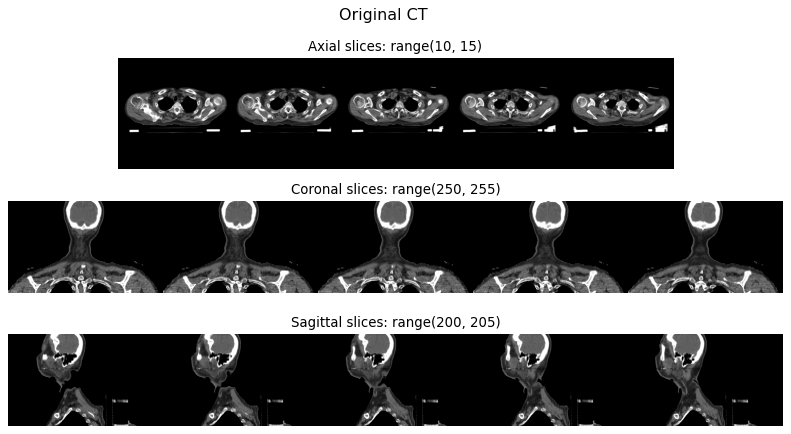

In [274]:
display_tile(sitk_image, 
             sagittal_slice_idxs=range(200,205),
             coronal_slice_idxs=range(250,255),
             axial_slice_idxs=range(10,15),
             window_level = 100,
             window_width = 500,
             title="Original CT")

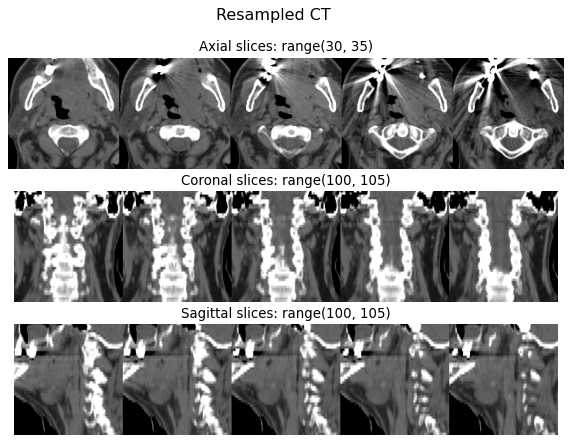

In [275]:
display_tile(sitk_res_image, 
             sagittal_slice_idxs=range(100,105),
             coronal_slice_idxs=range(100,105),
             axial_slice_idxs=range(30,35),
             window_level = 100,
             window_width = 500,
             title="Resampled CT")